# 🍽️ Food Classification using InceptionV3 with Real-World Testing
# 📌 Features:
# - Dataset split: 80k train / 10k val / 10k test (101 classes)
# - Transfer learning with InceptionV3 (ImageNet pre-trained)
# - Two-phase training: head training + fine-tuning
# - Data augmentation with rotation, shift, zoom, and flips
# - Includes confusion matrix, seaborn heatmaps, and real-world image prediction
# - Tracks top-1 and top-5 accuracy metrics
# - GPU-accelerated training with TensorFlow Metal
# - Model saved in .keras format for portability and future deployment

In [25]:
# =============================
# 📦 Imports
# =============================
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

In [8]:
# 📁 Dataset Directories
TRAIN_DIR = "/Users/raakeshmj/Programming/food-system/dataset/train"
VAL_DIR = "/Users/raakeshmj/Programming/food-system/dataset/val"
TEST_DIR = "/Users/raakeshmj/Programming/food-system/dataset/test"

# ⚙️ Config
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 64
EPOCHS_HEAD = 5
EPOCHS_FINE = 5
NUM_CLASSES = 101

In [9]:
# ✅ Confirm GPU Usage
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"✅ GPU detected: {physical_devices[0]}")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("❌ No GPU detected")

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [10]:
# 📊 Data Summary Function
def print_dataset_summary(directory, name):
    class_counts = {
        cls: len(os.listdir(os.path.join(directory, cls)))
        for cls in os.listdir(directory)
        if not cls.startswith(".")
    }
    print(f"\n📁 {name} Set: {sum(class_counts.values())} images across {len(class_counts)} classes")
    print(dict(list(class_counts.items())[:5]))  # first 5 classes as sample

print_dataset_summary(TRAIN_DIR, "Train")
print_dataset_summary(VAL_DIR, "Validation")
print_dataset_summary(TEST_DIR, "Test")


📁 Train Set: 80800 images across 101 classes
{'foie_gras': 800, 'club_sandwich': 800, 'cheese_plate': 800, 'cup_cakes': 800, 'garlic_bread': 800}

📁 Validation Set: 10100 images across 101 classes
{'foie_gras': 100, 'club_sandwich': 100, 'cheese_plate': 100, 'cup_cakes': 100, 'garlic_bread': 100}

📁 Test Set: 10100 images across 101 classes
{'foie_gras': 100, 'club_sandwich': 100, 'cheese_plate': 100, 'cup_cakes': 100, 'garlic_bread': 100}


In [11]:
#Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 80800 images belonging to 101 classes.
Found 10100 images belonging to 101 classes.
Found 10100 images belonging to 101 classes.


In [13]:
# Model Definition (Transfer Learning)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
x = base_model.output #48
x = GlobalAveragePooling2D()(x) #1
x = Dense(1024, activation='relu')(x) #1
predictions = Dense(NUM_CLASSES, activation='softmax')(x) #1
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers (train head only)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="top_5_accuracy")])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
]

In [14]:
#Step 1: Train top layers
print("\n⭐ Training Top Layers")
history_head = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_HEAD,
    callbacks=callbacks
)

# Unfreeze base model and continue training
print("\n💡 Fine-tuning Full Model")
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="top_5_accuracy")])

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_FINE,
    callbacks=callbacks
)


⭐ Training Top Layers


/Users/raakeshmj/miniforge3/envs/tf-metal/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


2025-04-10 19:55:59.052404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1263/1263 ━━━━━━━━━━━━━━━━━━━━ 615s 484ms/step - accuracy: 0.2900 - loss: 3.1616 - top_5_accuracy: 0.5256 - val_accuracy: 0.5289 - val_loss: 1.8505 - val_top_5_accuracy: 0.7992 - learning_rate: 1.0000e-04
Epoch 2/5
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 621s 491ms/step - accuracy: 0.5146 - loss: 1.9217 - top_5_accuracy: 0.7844 - val_accuracy: 0.5703 - val_loss: 1.6892 - val_top_5_accuracy: 0.8206 - learning_rate: 1.0000e-04
Epoch 3/5
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 608s 481ms/step - accuracy: 0.5496 - loss: 1.7518 - top_5_accuracy: 0.8100 - val_accuracy: 0.5912 - val_loss: 1.6077 - val_top_5_accuracy: 0.8323 - learning_rate: 1.0000e-04
Epoch 4/5
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 596s 471ms/step - accuracy: 0.5696 - loss: 1.6617 - top_5_accuracy: 0.8250 - val_accuracy: 0.5962 - val_loss: 1.5673 - val_top_5_accuracy: 0.8389 - learning_rate: 1.0000e-04
Epoch 5/5
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 603s 477ms/step - accuracy: 0.5809 - loss: 1.6162 - top_5_accuracy: 0.8328 - val_accuracy: 0.6072 - val_loss:

In [15]:
#Combine History
def combine_history(h1, h2):
    history = {}
    for key in h1.history:
        history[key] = h1.history[key] + h2.history.get(key, [])
    return history

history = combine_history(history_head, history_fine)

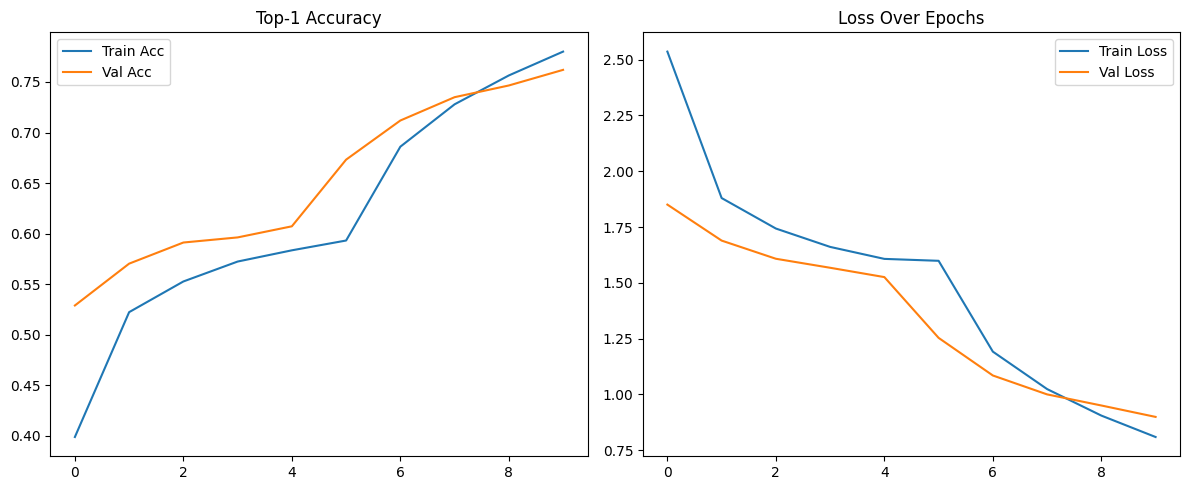

In [16]:
# Plot Accuracy & Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Acc')
plt.plot(history['val_accuracy'], label='Val Acc')
plt.title('Top-1 Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
#Evaluate on Test Set
print("\n📊 Evaluating on Test Set")
test_loss, test_acc, test_top5 = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}, Top-5 Accuracy: {test_top5:.4f}, Loss: {test_loss:.4f}")


📊 Evaluating on Test Set
158/158 ━━━━━━━━━━━━━━━━━━━━ 50s 317ms/step - accuracy: 0.7495 - loss: 0.9552 - top_5_accuracy: 0.9250
Test Accuracy: 0.7661, Top-5 Accuracy: 0.9292, Loss: 0.9001


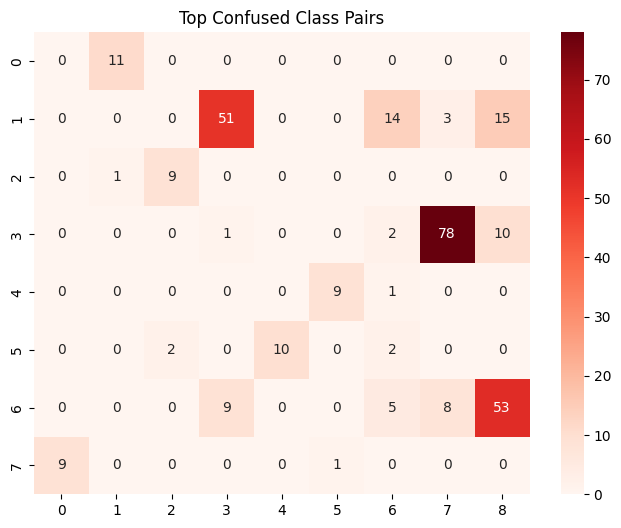

In [21]:
#Top Confused Classes
misclassified_counts = conf_matrix.copy()
np.fill_diagonal(misclassified_counts, 0)
top_confused = np.unravel_index(np.argsort(misclassified_counts, axis=None)[-10:], misclassified_counts.shape)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix[np.unique(top_confused[0])][:, np.unique(top_confused[1])], annot=True, fmt='d', cmap='Reds')
plt.title("Top Confused Class Pairs")
plt.show()

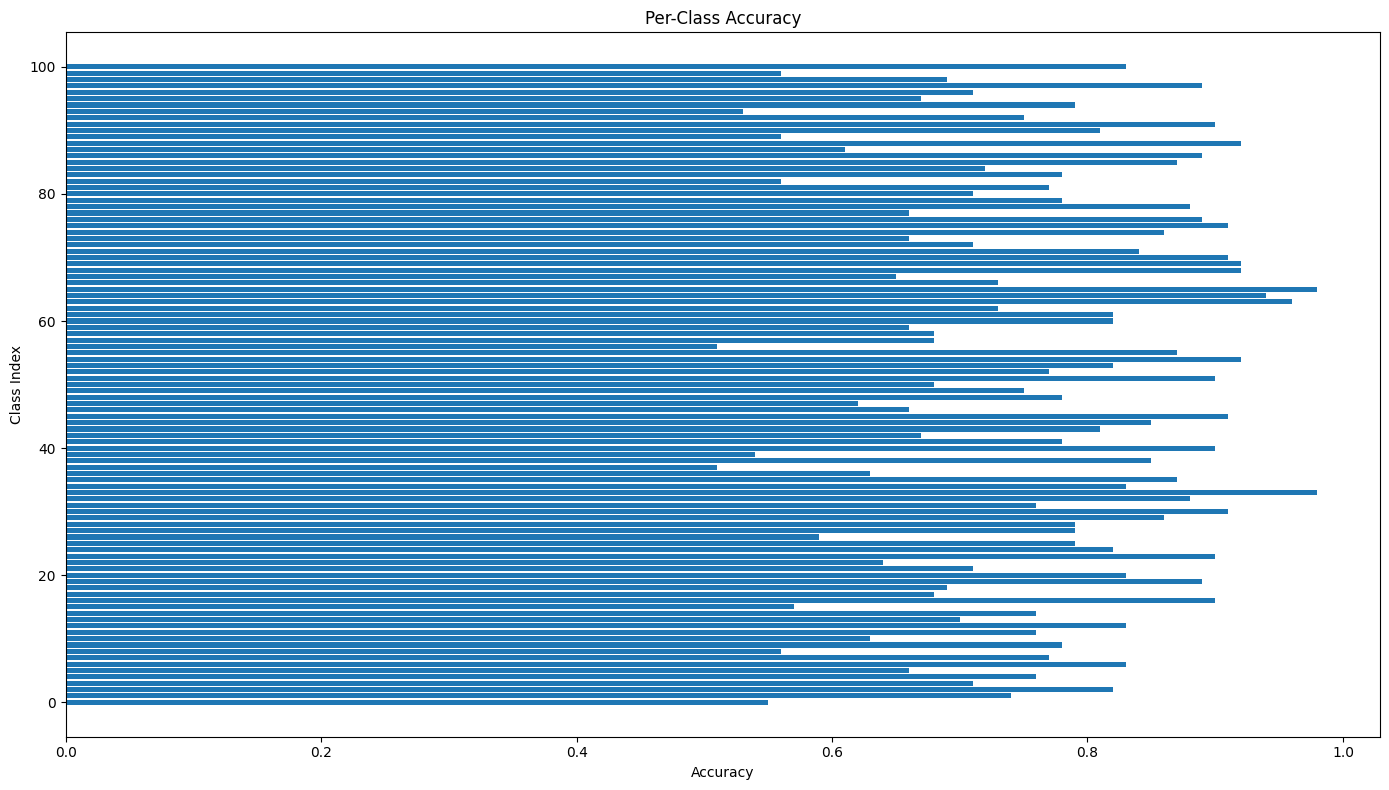

In [22]:
# 🎯 Per-Class Accuracy
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
plt.figure(figsize=(14, 8))
plt.barh(range(NUM_CLASSES), class_accuracies)
plt.title("Per-Class Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Class Index")
plt.tight_layout()
plt.show()


📊 Confusion Matrix
158/158 ━━━━━━━━━━━━━━━━━━━━ 65s 389ms/step


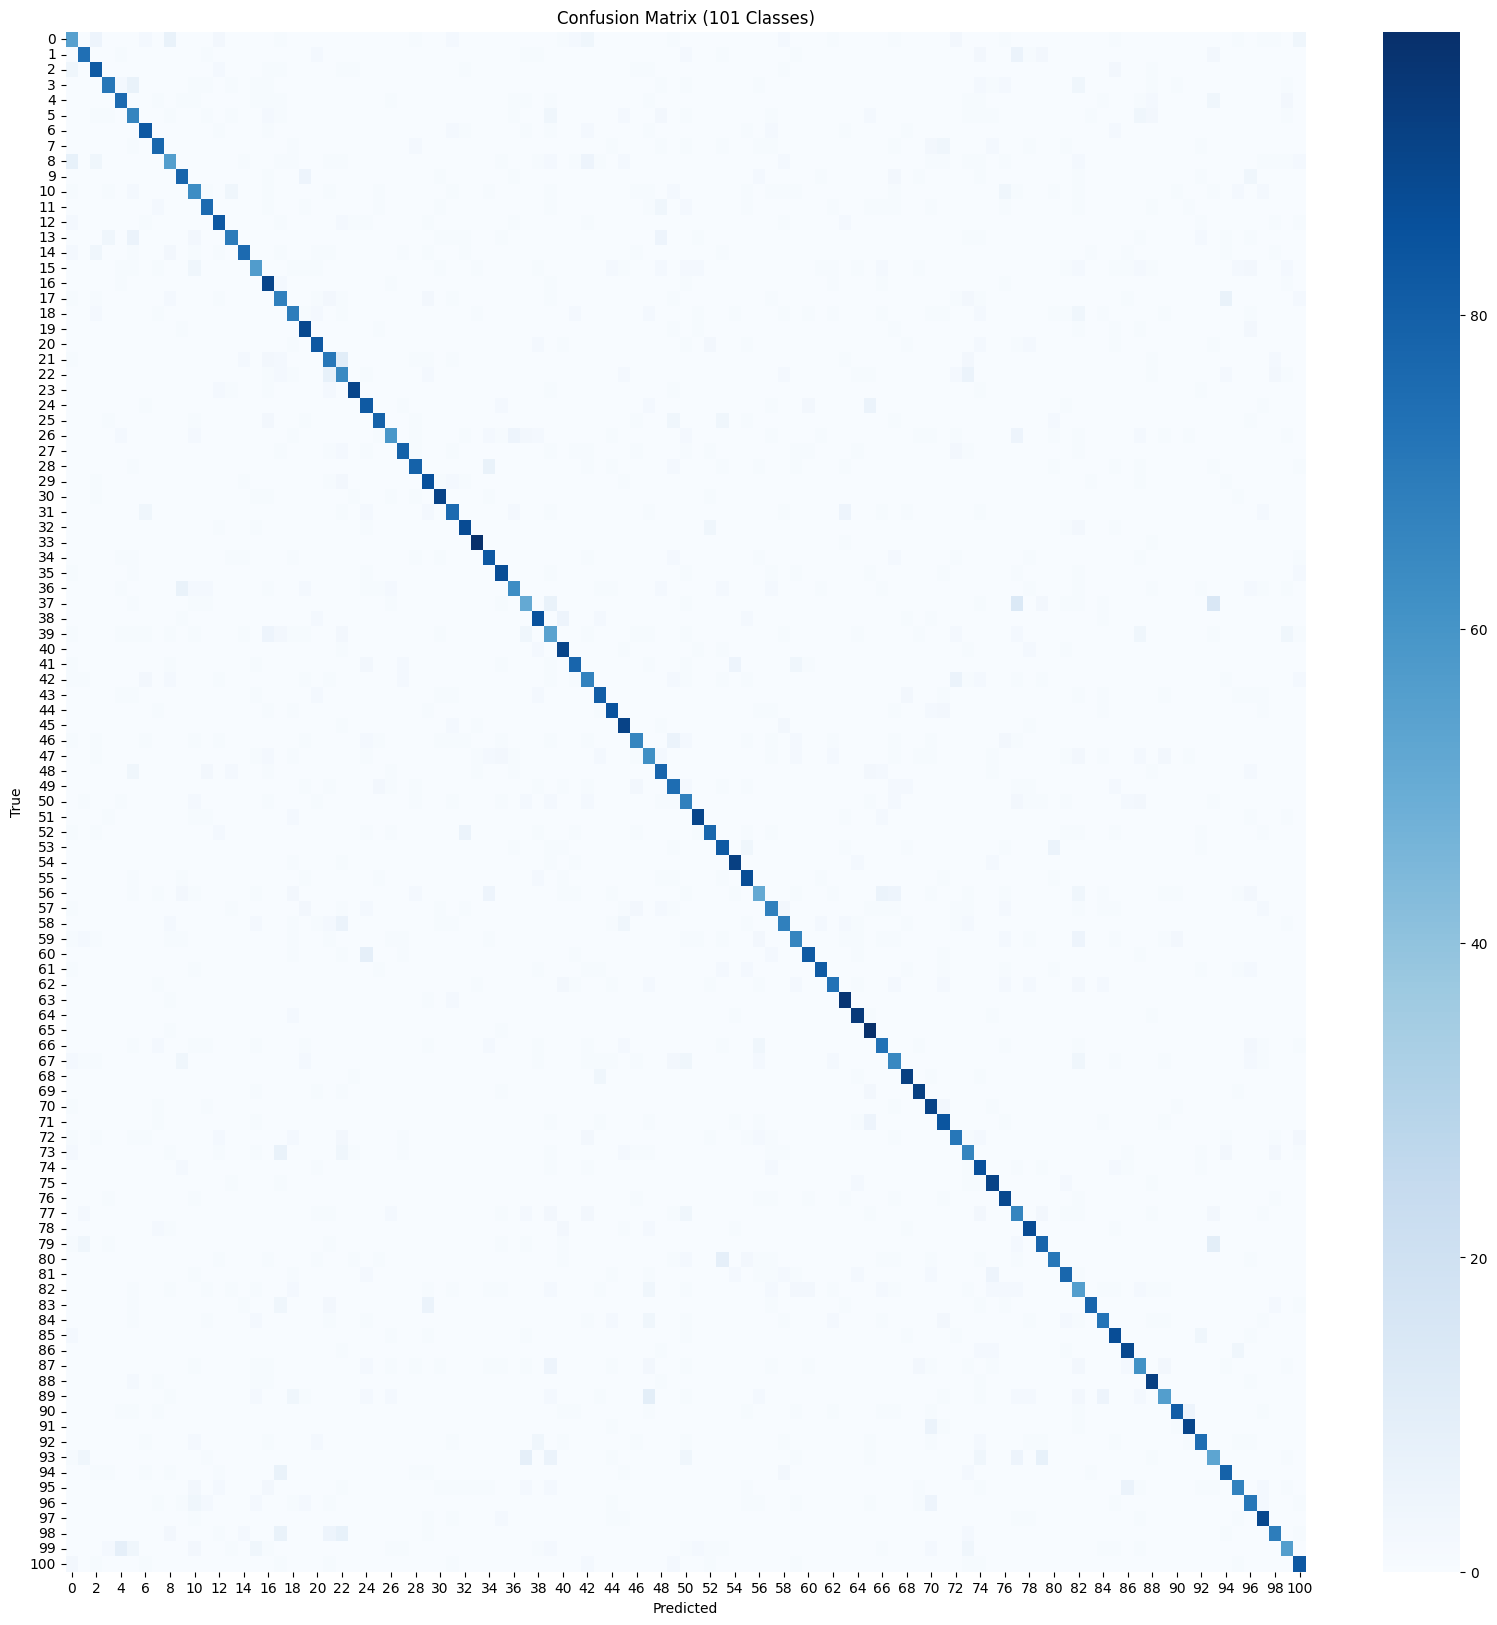

In [18]:
# Confusion Matrix
print("\n📊 Confusion Matrix")
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix (101 Classes)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [26]:
# 🧠 Precision-Recall Curve (macro)
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
precision = dict()
recall = dict()
avg_precision = dict()
for i in range(NUM_CLASSES):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], y_pred[:, i])

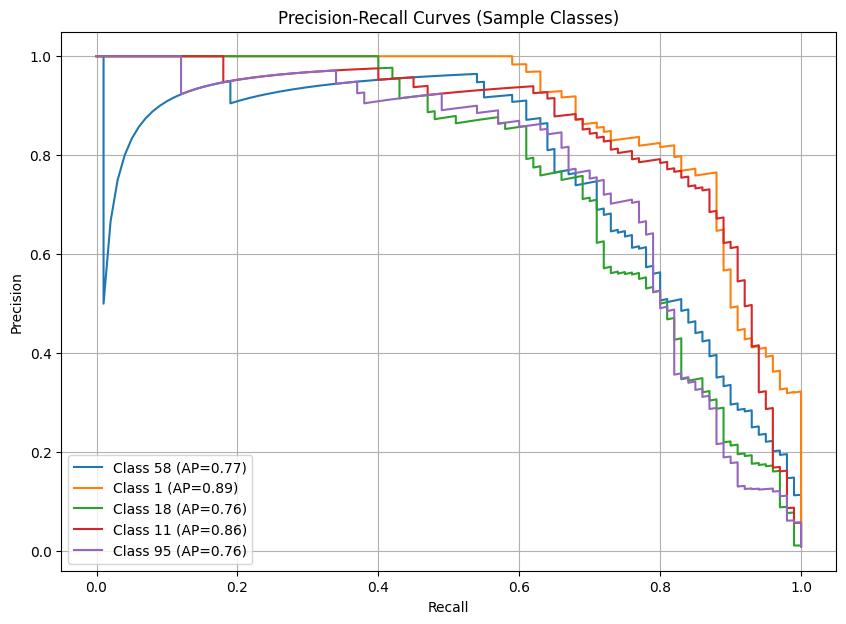

In [27]:
# Plot 5 random classes
plt.figure(figsize=(10, 7))
for i in np.random.choice(range(NUM_CLASSES), 5, replace=False):
    plt.plot(recall[i], precision[i], label=f"Class {i} (AP={avg_precision[i]:.2f})")
plt.title("Precision-Recall Curves (Sample Classes)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()


In [19]:

#Save the model in Keras format
model.save("food_inception_model.keras")
print("✅ Model saved as food_inception_model.keras")

✅ Model saved as food_inception_model.keras


In [32]:
#Real-World Testing

def predict_real_image(image_path):
    from tensorflow.keras.utils import load_img, img_to_array
    img = load_img(image_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    predicted_class = list(train_generator.class_indices.keys())[np.argmax(predictions)]
    print(f"Predicted Class: {predicted_class}")


# Example: predict_real_image('/path/to/your/food.jpg')

In [33]:
predict_real_image("/Users/raakeshmj/Programming/food-system/test_foiegras.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Class: foie_gras


In [34]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 147, 147,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 147, 147,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 73, 73,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 73, 73,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 71, 71,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 71,944,593 (274.45 MB)

 Trainable params: 23,970,053 (91.44 MB)

 Non-trainable params: 34,432 (134.50 KB)

 Optimizer params: 47,940,108 (182.88 MB)